## Used to create plots perform analysis of output produced by model.
- Output data will be saved as files and then imported here to analyse/plot.

In [1]:
import numpy as np
import numpy.polynomial.polynomial as poly
from scipy.optimize import curve_fit
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

mystyle = r'https://gist.githubusercontent.com/mbolt01/3087dffd11e70eccb08fdcf327374a5c/raw/std_fig'
plt.style.use(mystyle)

## can do my modelling in this notebook too.
import TCP_NTCP as model

## define colours and markers to use for each type
color_p = 'C0'
color_fc = 'C1'
color_hn = 'C2'

marker_p = 'o'
marker_fc = 's'
marker_hn = '^'

In [2]:
## functions to simply save and load files for use aftger producing modelling results

def save_pkl(obj,filename):
    pickle.dump(obj,open(filename,'wb'))

def load_pkl(filename):
    return pickle.load(open(filename,'rb'))

## example save:
#save_pkl(prost_10year,'test3.pkl')
## example load:
#newtest = load_pkl('test3.pkl')

In [3]:
## for reloading a module.
import importlib
importlib.reload(model)

<module 'TCP_NTCP' from 'C:\\Users\\Matt\\OneDrive\\PhD\\Quasar Shared\\Documents\\Thesis\\Corrections\\Code\\Thesis_code_corrections\\TCP_NTCP.py'>

## Re-do sensitivity plot.
- Vary the percentage variation of each (whilst keeping other parameters fixed).
- This might show some non-linearity.
- Do for 2 scenarios (prostate and H&N type steepness).

New parameter values to use:

#### Prost
- a/b = 1.5 +/-0.4 (this is ~25% SD as supported by literature values of alpha varying by 0.08 of 0.3)
- b = 0.03
- d = 2
- N0 = 60E7 based on tumour volume of 60cc and density of 10E7/cc
- TCP @ 74Gy = approx 55%

#### H&N
- a/b = 10 +/-2.5 (this is ~25% SD as supported by literature values of alpha varying by 0.08 of 0.3)
- b = 0.03
- d = 2
- N0 = 180E7 based on tumour volume of 180cc (CTV) and density of 10E7/cc
- TCP @ 65Gy = approx 66%

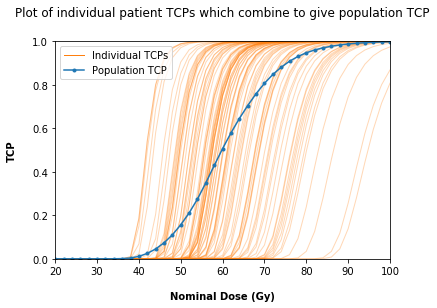

In [4]:
## Produce diagram showing individual patients and population for TCP. ** H&N
pop_n = 1000
TCP_results1 = model.completeTCPcalc(n=pop_n,                  # number of patients in population to model
                                       alphabeta_use=10,       # mean alpha/beta
                                       alphabeta_sd_use=20,    # SD of alpha/beta (%)
                                       d=2,                    # nominal dose (Gy/fraction)
                                       d_shift=0,              # initial dose difference (%)
                                       d_sd=0,                 # standard deviation of delivered dose (%)
                                       d_trend=0,              # dose drift (%/day)
                                       max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                       dose_of_interest=74,    # dose at which to return seperately the TCPs (Gy)
                                       n0 = 1E9,)          # N0 value supplied (if not supplied, then can be fitted)

## plot individual curves
for i in range(900,pop_n):
    plt.plot(TCP_results1['nom_doses'],TCP_results1['TCPs'][i],c='C1',
             alpha=0.3,lw=1, label = None)
    
## add fake line for legend with alpha = 1
plt.plot([-1,-1],[-1,-1],c='C1',
         alpha=1,lw=1, label = 'Individual TCPs')

## plot population curves
plt.plot(TCP_results1['nom_doses'],TCP_results1['TCP_pop'],ls='-',c='C0',
         label = 'Population TCP', marker='o',ms=3)
plt.xlim(20,100)
plt.ylim(0,1)
plt.legend(loc='upper left')

plt.xlabel('Nominal Dose (Gy)')
plt.ylabel('TCP')
plt.title('Plot of individual patient TCPs which combine to give population TCP')

#plt.savefig('pop_tcp_construction.png',dpi=300,bbox_inches='tight')

plt.show()

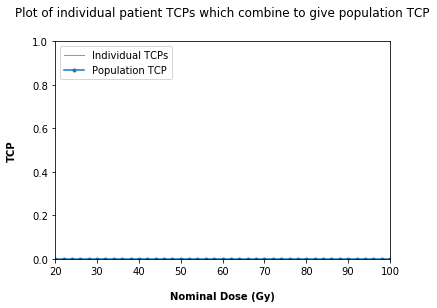

In [5]:
## Produce diagram showing individual patients and population for TCP. - ** PROSTATE
pop_n = 1000
TCP_results1 = model.completeTCPcalc(n=pop_n,                  # number of patients in population to model
                                       alphabeta_use=1.5,       # mean alpha/beta
                                       alphabeta_sd_use=20,    # SD of alpha/beta (%)
                                       d=2,                    # nominal dose (Gy/fraction)
                                       d_shift=0,              # initial dose difference (%)
                                       d_sd=0,                 # standard deviation of delivered dose (%)
                                       d_trend=0,              # dose drift (%/day)
                                       max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                       dose_of_interest=74,    # dose at which to return seperately the TCPs (Gy)
                                       n0 = 1E9,)          # N0 value supplied (if not supplied, then can be fitted)

## plot individual curves
for i in range(900,pop_n):
    plt.plot(TCP_results1['nom_doses'],TCP_results1['TCPs'][i],c='C1',
             alpha=0.3,lw=1, label = None)
    
## add fake line for legend with alpha = 1
plt.plot([-1,-1],[-1,-1],c='C1',
         alpha=1,lw=1, label = 'Individual TCPs')

## plot population curves
plt.plot(TCP_results1['nom_doses'],TCP_results1['TCP_pop'],ls='-',c='C0',
         label = 'Population TCP', marker='o',ms=3)
plt.xlim(20,100)
plt.ylim(0,1)
plt.legend(loc='upper left')

plt.xlabel('Nominal Dose (Gy)')
plt.ylabel('TCP')
plt.title('Plot of individual patient TCPs which combine to give population TCP')

#plt.savefig('pop_tcp_construction.png',dpi=300,bbox_inches='tight')

plt.show()

In [6]:
hn_std = model.completeTCPcalc(n=1,                  # number of patients in population to model
                            alphabeta_use=10,       # mean alpha/beta
                            alphabeta_sd_use=0,    # SD of alpha/beta (%)
                            d=2.167,                    # nominal dose (Gy/fraction)
                            d_shift=0,              # initial dose difference (%)
                            d_sd=0,                 # standard deviation of delivered dose (%)
                            d_trend=0,              # dose drift (%/day)
                            max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                            dose_of_interest=65,    # dose at which to return seperately the TCPs (Gy)
                            n0 = 4E9,)['TCP_cure_percent']          # N0 value supplied (if not supplied, then can be fitted)

prost_std = model.completeTCPcalc(n=1,                  # number of patients in population to model
                            alphabeta_use=1.5,       # mean alpha/beta
                            alphabeta_sd_use=0,    # SD of alpha/beta (%)
                            d=2,                    # nominal dose (Gy/fraction)
                            d_shift=0,              # initial dose difference (%)
                            d_sd=0,                 # standard deviation of delivered dose (%)
                            d_trend=0,              # dose drift (%/day)
                            max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                            dose_of_interest=74,    # dose at which to return seperately the TCPs (Gy)
                            n0 = 1.5E3,)['TCP_cure_percent']          # N0 value supplied (if not supplied, then can be fitted)

print('hn std',hn_std) # want 66%
print('prost std',prost_std) # want 55%
## standard TCP value for individual patient

hn std 64.6237037246
prost std 53.0826581171


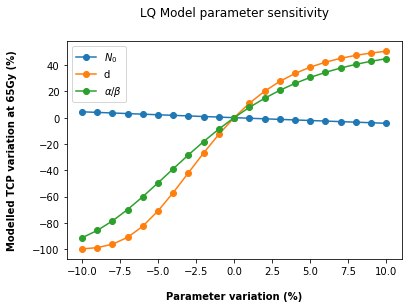

64.6237037246


In [7]:
## vary the difference parameters (for an individual patient - i.e. no SD on any param) to see impact on TCP at dose of interest
## do this for an individual patient and population?
## pop = use same params as for modelling
##  individual = get an N0 that gives TCP approx same as pop (will be much higher value)

## individual patient fixed params - H&N

hn_std = model.completeTCPcalc(n=1,                  # number of patients in population to model
                            alphabeta_use=10,       # mean alpha/beta
                            alphabeta_sd_use=0,    # SD of alpha/beta (%)
                            d=2.167,                    # nominal dose (Gy/fraction)
                            d_shift=0,              # initial dose difference (%)
                            d_sd=0,                 # standard deviation of delivered dose (%)
                            d_trend=0,              # dose drift (%/day)
                            max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                            dose_of_interest=65,    # dose at which to return seperately the TCPs (Gy)
                            n0 = 4E9,)['TCP_cure_percent']          # N0 value supplied (if not supplied, then can be fitted)

hn_std ## standard TCP value for individual patient

## now vary each parameter by X% and store the results

perc_var = [-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10]

## loop n0
hn_perc_dif_n0 = []
for perc in perc_var:
    #print(perc)
    hn_var = model.completeTCPcalc(n=1,                  # number of patients in population to model
                            alphabeta_use=10,       # mean alpha/beta
                            alphabeta_sd_use=0,    # SD of alpha/beta (%)
                            d=2.167,                    # nominal dose (Gy/fraction)
                            d_shift=0,              # initial dose difference (%)
                            d_sd=0,                 # standard deviation of delivered dose (%)
                            d_trend=0,              # dose drift (%/day)
                            max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                            dose_of_interest=65,    # dose at which to return seperately the TCPs (Gy)
                            n0 = 4E9*(1+(perc/100)))['TCP_cure_percent']          # N0 value supplied (if not supplied, then can be fitted)
    hn_var_dif_n0 = ((hn_var/hn_std)-1)*100
    hn_perc_dif_n0.append(hn_var_dif_n0)

## loop d
hn_perc_dif_d = []
for perc in perc_var:
    #print(perc)
    hn_var = model.completeTCPcalc(n=1,                  # number of patients in population to model
                            alphabeta_use=10,       # mean alpha/beta
                            alphabeta_sd_use=0,    # SD of alpha/beta (%)
                            d=2.167,                    # nominal dose (Gy/fraction)
                            d_shift=perc,              # initial dose difference (%)
                            d_sd=0,                 # standard deviation of delivered dose (%)
                            d_trend=0,              # dose drift (%/day)
                            max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                            dose_of_interest=65,    # dose at which to return seperately the TCPs (Gy)
                            n0 = 4E9)['TCP_cure_percent']          # N0 value supplied (if not supplied, then can be fitted)
    hn_var_dif_d = ((hn_var/hn_std)-1)*100
    hn_perc_dif_d.append(hn_var_dif_d)
    
## loop a/b
hn_perc_dif_ab = []
for perc in perc_var:
    #print(perc)
    hn_var = model.completeTCPcalc(n=1,                  # number of patients in population to model
                            alphabeta_use=10*(1+(perc/100)),       # mean alpha/beta
                            alphabeta_sd_use=0,    # SD of alpha/beta (%)
                            d=2.167,                    # nominal dose (Gy/fraction)
                            d_shift=0,              # initial dose difference (%)
                            d_sd=0,                 # standard deviation of delivered dose (%)
                            d_trend=0,              # dose drift (%/day)
                            max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                            dose_of_interest=65,    # dose at which to return seperately the TCPs (Gy)
                            n0 = 4E9)['TCP_cure_percent']          # N0 value supplied (if not supplied, then can be fitted)
    hn_var_dif_ab = ((hn_var/hn_std)-1)*100
    hn_perc_dif_ab.append(hn_var_dif_ab)

plt.plot(perc_var,hn_perc_dif_n0,marker='o',label=r'$N_0$')
plt.plot(perc_var,hn_perc_dif_d,marker='o',label='d')
plt.plot(perc_var,hn_perc_dif_ab,marker='o',label=r'$\alpha / \beta$')

plt.xlabel('Parameter variation (%)')
plt.ylabel('Modelled TCP variation at 65Gy (%)')
plt.title('LQ Model parameter sensitivity')

plt.legend()
plt.show()
print(hn_std)

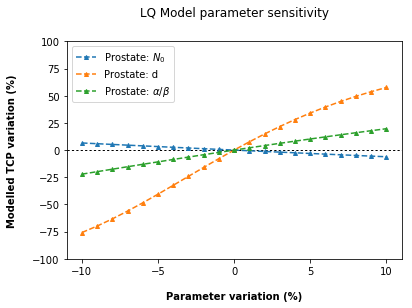

In [8]:
prost_std = model.completeTCPcalc(n=1,                  # number of patients in population to model
                            alphabeta_use=1.5,       # mean alpha/beta
                            alphabeta_sd_use=0,    # SD of alpha/beta (%)
                            d=2,                    # nominal dose (Gy/fraction)
                            d_shift=0,              # initial dose difference (%)
                            d_sd=0,                 # standard deviation of delivered dose (%)
                            d_trend=0,              # dose drift (%/day)
                            max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                            dose_of_interest=74,    # dose at which to return seperately the TCPs (Gy)
                            n0 = 1.5E3,)['TCP_cure_percent']          # N0 value supplied (if not supplied, then can be fitted)

prost_std ## standard TCP value for individual patient

## now vary each parameter by X% and store the results

perc_var = [-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10]

## loop n0
prost_perc_dif_n0 = []
for perc in perc_var:
    #print(perc)
    prost_var = model.completeTCPcalc(n=1,                  # number of patients in population to model
                            alphabeta_use=1.5,       # mean alpha/beta
                            alphabeta_sd_use=0,    # SD of alpha/beta (%)
                            d=2,                    # nominal dose (Gy/fraction)
                            d_shift=0,              # initial dose difference (%)
                            d_sd=0,                 # standard deviation of delivered dose (%)
                            d_trend=0,              # dose drift (%/day)
                            max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                            dose_of_interest=74,    # dose at which to return seperately the TCPs (Gy)
                            n0 = 1.5E3*(1+(perc/100)))['TCP_cure_percent']          # N0 value supplied (if not supplied, then can be fitted)
    prost_var_dif_n0 = ((prost_var/prost_std)-1)*100
    prost_perc_dif_n0.append(prost_var_dif_n0)

## loop d
prost_perc_dif_d = []
for perc in perc_var:
    #print(perc)
    prost_var = model.completeTCPcalc(n=1,                  # number of patients in population to model
                            alphabeta_use=1.5,       # mean alpha/beta
                            alphabeta_sd_use=0,    # SD of alpha/beta (%)
                            d=2,                    # nominal dose (Gy/fraction)
                            d_shift=perc,              # initial dose difference (%)
                            d_sd=0,                 # standard deviation of delivered dose (%)
                            d_trend=0,              # dose drift (%/day)
                            max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                            dose_of_interest=74,    # dose at which to return seperately the TCPs (Gy)
                            n0 = 1.5E3)['TCP_cure_percent']          # N0 value supplied (if not supplied, then can be fitted)
    prost_var_dif_d = ((prost_var/prost_std)-1)*100
    prost_perc_dif_d.append(prost_var_dif_d)
    
## loop a/b
prost_perc_dif_ab = []
for perc in perc_var:
    #print(perc)
    prost_var = model.completeTCPcalc(n=1,                  # number of patients in population to model
                            alphabeta_use=1.5*(1+(perc/100)),       # mean alpha/beta
                            alphabeta_sd_use=0,    # SD of alpha/beta (%)
                            d=2,                    # nominal dose (Gy/fraction)
                            d_shift=0,              # initial dose difference (%)
                            d_sd=0,                 # standard deviation of delivered dose (%)
                            d_trend=0,              # dose drift (%/day)
                            max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                            dose_of_interest=74,    # dose at which to return seperately the TCPs (Gy)
                            n0 = 1.5E3)['TCP_cure_percent']          # N0 value supplied (if not supplied, then can be fitted)
    prost_var_dif_ab = ((prost_var/prost_std)-1)*100
    prost_perc_dif_ab.append(prost_var_dif_ab)

plt.plot(perc_var,prost_perc_dif_n0,ls='--',marker='^',ms=4,label=r'Prostate: $N_0$')
plt.plot(perc_var,prost_perc_dif_d,ls='--',marker='^',ms=4,label='Prostate: d')
plt.plot(perc_var,prost_perc_dif_ab,ls='--',marker='^',ms=4,label=r'Prostate: $\alpha / \beta$')

plt.xlabel('Parameter variation (%)')
plt.ylabel('Modelled TCP variation (%)')
plt.title('LQ Model parameter sensitivity')
plt.xticks([-10,-5,0,5,10])
plt.axhline(0,color='black',ls=':',lw=1,zorder=0)
plt.ylim(-100,100)

plt.legend()
plt.show()

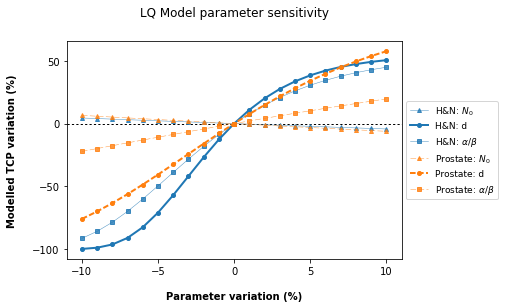

In [30]:
## plot all on same axis

plt.plot(perc_var,hn_perc_dif_n0,lw=0.5,alpha=0.8,ls='-',marker='^',ms=4,label=r'H&N: $N_0$',c='C0')
plt.plot(perc_var,hn_perc_dif_d,lw=2,alpha=1,ls='-',marker='o',ms=4,label='H&N: d',c='C0')
plt.plot(perc_var,hn_perc_dif_ab,lw=0.5,alpha=0.8,ls='-',marker='s',ms=4,label=r'H&N: $\alpha / \beta$',c='C0')

plt.plot(perc_var,prost_perc_dif_n0,lw=0.5,alpha=0.8,ls='--',marker='^',ms=4,label=r'Prostate: $N_0$',c='C1')
plt.plot(perc_var,prost_perc_dif_d,lw=2,alpha=1,ls='--',marker='o',ms=4,label='Prostate: d',c='C1')
plt.plot(perc_var,prost_perc_dif_ab,lw=0.5,alpha=0.8,ls='--',marker='s',ms=4,label=r'Prostate: $\alpha / \beta$',c='C1')

plt.xlabel('Parameter variation (%)')
plt.ylabel('Modelled TCP variation (%)')
plt.title('LQ Model parameter sensitivity')
plt.xticks([-10,-5,0,5,10])
plt.axhline(0,color='black',ls=':',lw=1,zorder=0)
#plt.ylim(-100,80)
plt.yticks([-100,-50,0,50])

plt.legend(fontsize=9,loc='center left', bbox_to_anchor=(1, 0.5))
#plt.savefig('LQ_sensitivity.png',dpi=300,bbox_inches='tight')
plt.show()

# Same as above but for LKB model


Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
0.661886810255
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulatio

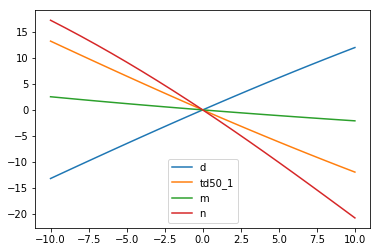

In [12]:
## this TCP part is only used to get a list of fraction doses and nominal doses
## this is easiest as the dose variaiotn is builtin.
TCP_results_hn = model.completeTCPcalc(n=1,
                                      alphabeta_use=10,
                                      alphabeta_sd_use=0,
                                      d=65/30,
                                      d_shift=0, # no shift as start each treatment as if perfect
                                      d_sd=0,
                                      d_trend=0, # vary the trend value
                                      max_d=100,
                                      dose_of_interest=65,
                                      n0 = 4E9) ##*********

frac_doses_hn = TCP_results_hn['doses']
nom_doses_hn = TCP_results_hn['nom_doses'] 

## v is manually determined based ont he TCP/dose points


NTCP_results_hn = model.complete_NTCP_calc(d_data=[65],
                                       ntcp_data=[0.66],
                                       irrad_perc = 100, ## scaling factor?
                                       frac_doses=frac_doses_hn,
                                       max_dose=100,
                                       ntcp_params={'td50_1':(31.4,0),
                                                    'v': (0.59,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                    'm':(0.53,0),
                                                    'n':(1,0)}, #(1,0)
                                       fit_vals=False)

#array posn of interest prost = 36, hn = 29

ntcp_std_hn = NTCP_results_hn['patient_ntcps'][0][29]

print(ntcp_std_hn)

perc_var = [-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10]

## H&N

# vary d
ntcp_hn_var_d = []
for perc in perc_var:
    NTCP_results_hn = model.complete_NTCP_calc(d_data=[65],
                                       ntcp_data=[0.66],
                                       irrad_perc = 100, ## scaling factor?
                                       frac_doses=frac_doses_hn*(1+(perc/100)),
                                       max_dose=100,
                                       ntcp_params={'td50_1':(31.4,0),
                                                    'v': (0.59,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                    'm':(0.53,0),
                                                    'n':(1,0)}, #(1,0)
                                       fit_vals=False)['patient_ntcps'][0][29]
    ntcp_hn_var_d_perc = ((NTCP_results_hn/ntcp_std_hn)-1)*100
    ntcp_hn_var_d.append(ntcp_hn_var_d_perc)

# vary td50_1
ntcp_hn_var_td50 = []
for perc in perc_var:
    NTCP_results_hn = model.complete_NTCP_calc(d_data=[65],
                                       ntcp_data=[0.66],
                                       irrad_perc = 100, ## scaling factor?
                                       frac_doses=frac_doses_hn,
                                       max_dose=100,
                                       ntcp_params={'td50_1':(31.4*(1+(perc/100)),0),
                                                    'v': (0.59,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                    'm':(0.53,0),
                                                    'n':(1,0)}, #(1,0)
                                       fit_vals=False)['patient_ntcps'][0][29]
    ntcp_hn_var_td50_perc = ((NTCP_results_hn/ntcp_std_hn)-1)*100
    ntcp_hn_var_td50.append(ntcp_hn_var_td50_perc)  

# vary m
ntcp_hn_var_m = []
for perc in perc_var:
    NTCP_results_hn = model.complete_NTCP_calc(d_data=[65],
                                       ntcp_data=[0.66],
                                       irrad_perc = 100, ## scaling factor?
                                       frac_doses=frac_doses_hn,
                                       max_dose=100,
                                       ntcp_params={'td50_1':(31.4,0),
                                                    'v': (0.59,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                    'm':(0.53*(1+(perc/100)),0),
                                                    'n':(1,0)}, #(1,0)
                                       fit_vals=False)['patient_ntcps'][0][29]
    ntcp_hn_var_m_perc = ((NTCP_results_hn/ntcp_std_hn)-1)*100
    ntcp_hn_var_m.append(ntcp_hn_var_m_perc) 

# vary n
ntcp_hn_var_n = []
for perc in perc_var:
    NTCP_results_hn = model.complete_NTCP_calc(d_data=[65],
                                       ntcp_data=[0.66],
                                       irrad_perc = 100, ## scaling factor?
                                       frac_doses=frac_doses_hn,
                                       max_dose=100,
                                       ntcp_params={'td50_1':(31.4,0),
                                                    'v': (0.59*(1-(perc/100)),0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                    'm':(0.53,0),
                                                    'n':(1*(1+(perc/100)),0)}, #(1,0)
                                       fit_vals=False)['patient_ntcps'][0][29]
    ntcp_hn_var_n_perc = ((NTCP_results_hn/ntcp_std_hn)-1)*100
    ntcp_hn_var_n.append(ntcp_hn_var_n_perc) 
    
plt.plot(perc_var,ntcp_hn_var_d,label='d')
plt.plot(perc_var,ntcp_hn_var_td50,label='td50_1')
plt.plot(perc_var,ntcp_hn_var_m,label='m')
plt.plot(perc_var,ntcp_hn_var_n,label='n')
plt.legend()
plt.show()

Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
0.597382175553
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulatio

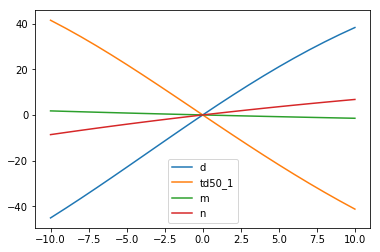

In [16]:
## this TCP part is only used to get a list of fraction doses and nominal doses
## this is easiest as the dose variaiotn is builtin.
TCP_results_p = model.completeTCPcalc(n=1,
                                      alphabeta_use=1.5,
                                      alphabeta_sd_use=0,
                                      d=2,
                                      d_shift=0, # no shift as start each treatment as if perfect
                                      d_sd=0,
                                      d_trend=0, # vary the trend value
                                      max_d=100,
                                      dose_of_interest=74,
                                      n0 = 1.5E3) ##*********

frac_doses_p = TCP_results_p['doses']
nom_doses_p = TCP_results_p['nom_doses'] 

## v is manually determined based ont he TCP/dose points


NTCP_results_p = model.complete_NTCP_calc(d_data=[64,74],
                                       ntcp_data=[0.36,0.47],
                                       irrad_perc = 100, ## scaling factor?
                                       frac_doses=frac_doses_p,
                                       max_dose=100,
                                       ntcp_params={'td50_1':(68.5,0),
                                                    'v': (0.73,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                    'm':(0.15,0),
                                                    'n':(0.13,0)}, #(1,0)
                                       fit_vals=False)

#array posn of interest prost = 36, hn = 29

ntcp_std_p = NTCP_results_p['patient_ntcps'][0][36]

print(ntcp_std_p)

perc_var = [-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10]

## Prostate

# vary d
ntcp_p_var_d = []
for perc in perc_var:
    NTCP_results_p = model.complete_NTCP_calc(d_data=[64,74],
                                       ntcp_data=[0.36,0.47],
                                       irrad_perc = 100, ## scaling factor?
                                       frac_doses=frac_doses_p*(1+(perc/100)),
                                       max_dose=100,
                                       ntcp_params={'td50_1':(68.5,0),
                                                    'v': (0.73,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                    'm':(0.15,0),
                                                    'n':(0.13,0)}, #(1,0)
                                       fit_vals=False)['patient_ntcps'][0][36]
    ntcp_p_var_d_perc = ((NTCP_results_p/ntcp_std_p)-1)*100
    ntcp_p_var_d.append(ntcp_p_var_d_perc)

# vary td50_1
ntcp_p_var_td50 = []
for perc in perc_var:
    NTCP_results_p = model.complete_NTCP_calc(d_data=[64,74],
                                       ntcp_data=[0.36,0.47],
                                       irrad_perc = 100, ## scaling factor?
                                       frac_doses=frac_doses_p,
                                       max_dose=100,
                                       ntcp_params={'td50_1':(68.5*(1+(perc/100)),0),
                                                    'v': (0.73,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                    'm':(0.15,0),
                                                    'n':(0.13,0)}, #(1,0)
                                       fit_vals=False)['patient_ntcps'][0][36]
    ntcp_p_var_td50_perc = ((NTCP_results_p/ntcp_std_p)-1)*100
    ntcp_p_var_td50.append(ntcp_p_var_td50_perc)  

# vary m
ntcp_p_var_m = []
for perc in perc_var:
    NTCP_results_p = model.complete_NTCP_calc(d_data=[64,74],
                                       ntcp_data=[0.36,0.47],
                                       irrad_perc = 100, ## scaling factor?
                                       frac_doses=frac_doses_p,
                                       max_dose=100,
                                       ntcp_params={'td50_1':(68.5,0),
                                                    'v': (0.73,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                    'm':(0.15*(1+(perc/100)),0),
                                                    'n':(0.13,0)}, #(1,0)
                                       fit_vals=False)['patient_ntcps'][0][36]
    ntcp_p_var_m_perc = ((NTCP_results_p/ntcp_std_p)-1)*100
    ntcp_p_var_m.append(ntcp_p_var_m_perc) 

# vary n
ntcp_p_var_n = []
for perc in perc_var:
    NTCP_results_p = model.complete_NTCP_calc(d_data=[64,74],
                                       ntcp_data=[0.36,0.47],
                                       irrad_perc = 100, ## scaling factor?
                                       frac_doses=frac_doses_p,
                                       max_dose=100,
                                       ntcp_params={'td50_1':(68.5,0),
                                                    'v': (0.73*(1+(perc/100)),0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                    'm':(0.15,0),
                                                    'n':(0.13*(1-(perc/100)),0)}, #(1,0)
                                       fit_vals=False)['patient_ntcps'][0][36]
    ntcp_p_var_n_perc = ((NTCP_results_p/ntcp_std_p)-1)*100
    ntcp_p_var_n.append(ntcp_p_var_n_perc) 
    
plt.plot(perc_var,ntcp_p_var_d,label='d')
plt.plot(perc_var,ntcp_p_var_td50,label='td50_1')
plt.plot(perc_var,ntcp_p_var_m,label='m')
plt.plot(perc_var,ntcp_p_var_n,label='n')
plt.legend()
plt.show()

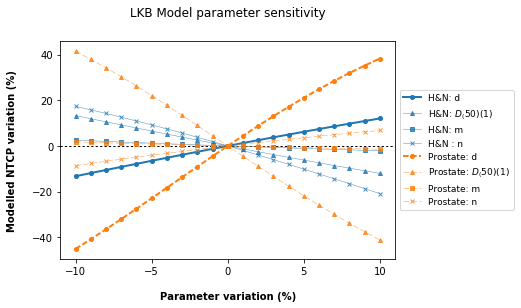

In [28]:
##Plot of prost + H&N results

plt.plot(perc_var,ntcp_hn_var_d,c='C0',alpha=1,marker='o',ms=4,lw=2,ls='-',label='H&N: d')
plt.plot(perc_var,ntcp_hn_var_td50,c='C0',alpha=0.8,marker='^',ms=4,lw=0.5,ls='-',label=r'H&N: $D_(50)(1)$')
plt.plot(perc_var,ntcp_hn_var_m,c='C0',alpha=0.8,marker='s',ms=4,lw=0.5,ls='-',label='H&N: m')
plt.plot(perc_var,ntcp_hn_var_n,c='C0',alpha=0.8,marker='x',ms=4,lw=0.5,ls='-',label='H&N : n')

plt.plot(perc_var,ntcp_p_var_d,c='C1',alpha=1,marker='o',ms=4,lw=2,ls='--',label='Prostate: d')
plt.plot(perc_var,ntcp_p_var_td50,c='C1',alpha=0.8,marker='^',lw=0.5,ms=4,ls='--',label=r'Prostate: $D_(50)(1)$')
plt.plot(perc_var,ntcp_p_var_m,c='C1',alpha=0.8,marker='s',ms=4,lw=0.5,ls='--',label='Prostate: m')
plt.plot(perc_var,ntcp_p_var_n,c='C1',alpha=0.8,marker='x',ms=4,lw=0.5,ls='--',label='Prostate: n')

plt.xlabel('Parameter variation (%)')
plt.ylabel('Modelled NTCP variation (%)')
plt.title('LKB Model parameter sensitivity')
plt.xticks([-10,-5,0,5,10])
plt.axhline(0,color='black',ls=':',lw=1,zorder=0)

plt.legend(fontsize=9,loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('LKB_sensitivity.png',dpi=300,bbox_inches='tight')
plt.show()

In [107]:
TCP_results_p = model.completeTCPcalc(n=1,
                                      alphabeta_use=1.5,
                                      alphabeta_sd_use=0,
                                      d=2,
                                      d_shift=0, # no shift as start each treatment as if perfect
                                      d_sd=0,
                                      d_trend=0, # vary the trend value
                                      max_d=100,
                                      dose_of_interest=74,
                                      n0 = 1.5E3) ##*********

frac_doses_p = TCP_results_p['doses']
nom_doses_p = TCP_results_p['nom_doses']

NTCP_results_p = model.complete_NTCP_calc(d_data=[64,74],
                                       ntcp_data=[0.36,0.47],
                                       irrad_perc = 100, ## scaling factor?
                                       frac_doses=frac_doses_p,
                                       max_dose=100,
                                       ntcp_params={'td50_1':(68.5,0),
                                                    'v': (0.73,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                    'm':(0.15,0),
                                                    'n':(0.13,0)}, #(1,0)
                                       fit_vals=False)

ntcp_std_p = NTCP_results_p['patient_ntcps'][0][36]
print(ntcp_std_p)

Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
0.597382175553


In [98]:
frac_doses_hn*1.1

array([[ 2.383,  2.383,  2.383,  2.383,  2.383,  2.383,  2.383,  2.383,
         2.383,  2.383,  2.383,  2.383,  2.383,  2.383,  2.383,  2.383,
         2.383,  2.383,  2.383,  2.383,  2.383,  2.383,  2.383,  2.383,
         2.383,  2.383,  2.383,  2.383,  2.383,  2.383,  2.383,  2.383,
         2.383,  2.383,  2.383,  2.383,  2.383,  2.383,  2.383,  2.383,
         2.383,  2.383,  2.383,  2.383,  2.383,  2.383,  2.383]])

# Variation of calculated TCP with value of 'n' used to determine a/b SD.
- Do for both prostate and H&N simulations.
- Plot SEOM of TCPs vs 'n'

In [2]:
## model was run manually to determine fitting parameters whilst varying the value of 'n'.
## the head and neck case will show greatest variation in calcualted TCP with small changes
## due to the steeper curve, and so is used.
## results in dect below: {n:results(repeated 10x to allow stat generation)}

fit_results = {5:[68.406009678647749, 67.608578321726924, 49.821790032518166, 45.190450525393523, 42.263650309713491, 48.280971976140904, 55.593188493038497, 65.765537244765937, 48.716297686044634, 63.894422912789786],
              10:[44.607610720974769, 59.644050191499105, 45.649958125947826, 48.201517190312551, 62.203171193300193, 56.059277214538284, 46.766975439753189, 42.59743002671965, 60.878837384043422, 57.832597402335175],
              15:[49.39731034557856, 48.255443292806703, 56.698017166294349, 52.458885863998532, 59.111644282190753, 78.764752119408854, 46.852738446606516, 55.178333265124834, 77.296440094513187, 49.786733454251682],
              20:[62.78387224204333, 44.976300431874222, 65.675863304615675, 68.49897660904773, 50.227469883196676, 42.688178452306985, 67.727511833499534, 77.368889574745197, 67.156014984018995, 46.776049208943562],
              25:[58.150631697711972, 60.864352277966546, 45.916589087898743, 51.827995893372709, 66.126926732924389, 77.723091441570659, 63.305096105328992, 50.947201146564254, 47.313871453736922, 58.555962663381955],
              30:[69.718951787139488, 55.76643757384781, 65.312865778838457, 58.578099527640823, 67.035473227099715, 54.439461989093516, 45.176110666847215, 60.180795891534785, 60.596576538144717, 66.752559267840638],
              40:[58.02509860983789, 73.762931201556583, 58.647862475398782, 64.634666397276547, 53.067832482927884, 64.662343265573426, 63.359872182949886, 69.660662220460523, 65.783921455962513, 68.296310392266932],
              50:[63.709674454552555, 65.240797192293712, 66.923117690265244, 66.828597873210157, 45.062721760548207, 68.278187046443421, 56.544365971262714, 47.454735487538485, 64.040426818192714, 56.74721214109627],
              60:[68.284246309492502, 63.875536843593665, 58.239324721369165, 64.445447189161271, 72.787664625004979, 69.490086503595009, 68.486819342045578, 60.918597887257818, 48.851404219432219, 67.558321260017351],
              75:[66.450789948360125, 65.184076937799176, 71.974477574787215, 59.353297355914904, 68.905055473698212, 62.201488119821569, 56.69219817763318, 65.329671163187939, 62.317515892195104, 65.35954592727974],
              100:[65.24509543812411, 68.393599369715787, 48.919362824330946, 59.370359780776198, 68.285918026938532, 60.277469931683115, 68.826223488323279, 62.945646732168122, 69.200965950379015, 64.880467443159247],
              150:[62.756842609385103, 64.699075079865381, 70.005174810933781, 68.755667838198335, 66.938499854112081, 49.974763695147722, 69.331424380532354, 64.437990398886384, 66.624165622003417, 67.156188499756368],
              200:[64.159630578320503, 62.698351933098046, 69.188233119441605, 64.259238862010278, 64.445260321798173, 67.682893617985968, 67.257496331796688, 64.259436660324681, 67.14594787662007, 65.687001629099541],
              300:[66.100108236650939, 65.76087121935393, 69.166768014396197, 67.604877203297519, 66.099862651294373, 65.275805756964658, 67.255990394071233, 68.331222963964166, 62.628439351129785, 62.653425230845706],
              400:[64.771358216392073, 69.992308363768132, 55.634940672198319, 68.956947348932985, 69.958484713895587, 65.804716650742989, 65.576980358892811, 65.101434096700814, 68.949349592688989, 66.821558806879381],
              500:[68.256861044282203, 65.873668613381852, 63.295810002214239, 62.198481474258074, 67.091879628682364, 64.386410789156841, 65.130391194853019, 65.613182101236418, 66.916876802538937, 68.06820130124872],
              750:[68.020648802988461, 68.89368624828802, 65.440218233724025, 66.623989407150773, 68.245980658289568, 68.299719465564152, 67.00881571307886, 69.054225921285791, 66.45542612229471, 63.822449869223249],
              1000:[67.223691810398591, 64.930582239319889, 64.126594554258773, 71.306144879484606, 64.173359779749291, 67.205405182283087, 68.14163673775262, 66.044265702673471, 67.634065762632119, 62.49568117456031],
              1500:[65.298053388674674, 67.708146968578063, 66.395916057845326, 65.958196985028351, 66.712804916636713, 66.243387679922165, 66.958323235373328, 65.950170446626331, 67.293545191954223, 64.882680939175501],
              2000:[67.408870827003724, 69.309830432845928, 68.760405417544831, 69.313632957855134, 64.997335547573584, 67.29580481793873, 66.173610213348439, 67.415356243519298, 64.250583048703106, 67.53557312088698],
              3000:[64.915715585242538, 66.098086994799758, 65.87249079508328, 65.741109886405454, 65.627260190631517, 68.636551043804261, 65.698834570774224, 69.164540299279977, 65.085637548800634, 68.659989163654103],
              5000:[66.908770881512552, 67.850006695608755, 66.099526709382758, 66.785173002863033, 67.382511348301591, 67.904898520773585, 65.957527943104566, 65.120548093237119, 65.442151736822169, 66.458381225527361],
              }

fit_results_5 = {5:[54.011541970926189, 48.953485637075637, 51.520832075694976, 54.563364768830795, 60.718248080179826, 49.853476602103534, 55.375724907058746, 60.258906306359563, 55.950507710042714, 50.040825119751993],
                10:[46.819920022908363, 56.668507060202202, 64.988903197596784, 54.831776979989513, 52.384320659571621, 57.285881518668532, 54.023363997968126, 55.162516653110565, 54.079914752391119, 53.15204011782432],
                15:[52.968239436648645, 51.149196175032749, 59.624279195391253, 55.437095479881748, 51.833362669109832, 51.919080940202967, 56.664393853677616, 65.304137959693733, 52.408213346560863, 56.352802853525162],
                20:[65.410539268795418, 56.191834067495641, 54.064025254566751, 59.855151630613975, 52.625822519731422, 54.323647225513739, 61.852017397434203, 55.483855258759448, 53.794684999416354, 57.437545077875093],
                25:[63.870897849150289, 51.372790119741879, 54.413596767495505, 53.746712964776883, 56.276266811023902, 56.710583056023175, 52.619947750473145, 54.002373966440487, 55.541089919411114, 54.949197179024004],
                30:[67.358801468202927, 67.096216515815669, 57.587820964098363, 52.989027181425762, 50.166338010710831, 60.46599354930165, 60.771008486794486, 55.79856588509822, 57.544066642293082, 65.162908725314992],
                40:[60.09711499368774, 57.887830965400099, 59.907405428489213, 57.050481122474935, 57.020880998178654, 53.467951520422666, 55.206199310861265, 60.435958555805819, 62.881473420251794, 63.316509644232042],
                50:[66.347635203951455, 63.789626953876947, 59.400015206524586, 57.139188676038806, 65.063312923075344, 59.240689992378911, 65.011261478873735, 61.571490426182528, 53.249585227463747, 60.102864733671659],
                60:[62.932283157867701, 56.080081030918294, 58.253610604839196, 57.387825722759672, 56.278762510463842, 62.804395924367078, 58.930991774363349, 66.499670455896123, 59.881958369691787, 61.299816789721852],
                75:[65.199315568495464, 64.076758431511294, 60.609744815440941, 64.673380055637637, 62.256985013018557, 66.734703161309682, 65.597224334354095, 63.901419280001733, 61.363189553930837, 58.532211327807772],
                100:[64.151133523847562, 62.005494452675741, 62.627933537367021, 62.365965210221816, 56.509232074739977, 68.588358818412459, 62.177267948977295, 56.31105259999665, 59.830770268426818, 65.105723184848642],
                150:[],
                200:[],
                300:[],
                400:[],
                500:[65.192255748546543, 67.200930809824385, 65.584672890690925, 64.60567797642932, 66.819137767163227, 66.427927636910482, 65.813982366550078, 67.416301067051108, 68.717933705150458, 64.372347848694091],
                }

## no difference is seen with the total population size when repeats are included. Mention, or ignore as expected mathematically?

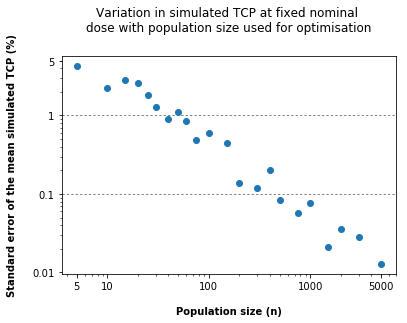

In [18]:
for i in fit_results:
    plt.loglog(i,np.std(fit_results[i])/np.sqrt(i),'o',c='C0')
    
## get error bars from SD of results?
    
#for i in fit_results_5:
#    plt.semilogx(i*5,np.std(fit_results_5[i])/np.sqrt(len(fit_results_5[i])),'x',c='C1')    
    
plt.yticks([0.01,0.1,1,5],['0.01','0.1','1','5'])
plt.xticks([5,10,100,1000,5000],['5','10','100','1000','5000'])
plt.title('Variation in simulated TCP at fixed nominal \ndose with population size used for optimisation')
plt.xlabel('Population size (n)')
#plt.ylim(0,4)
plt.ylabel('Standard error of the mean simulated TCP (%)')
for j in [0.1,1]:
    plt.axhline(j,ls=':',c='black',zorder=0,lw=0.5)
#plt.savefig('SEOM in TCP with variation in n.png',dpi=300,bbox_inches='tight')
plt.show()
## SEOM <0.1% at n=500, so use this for modelling results.

In [2]:
## repeat above with updated data x3

In [3]:
n_results=np.load('n_results.npy').item()
n_results1=np.load('n_results1.npy').item()
n_results2=np.load('n_results2.npy').item()
data_ns = [i for i in sorted(n_results)]
data_hn = [np.std(n_results[i])/np.sqrt(i) for i in sorted(n_results)]
data_rt01 = [np.std(n_results1[i])/np.sqrt(i) for i in sorted(n_results1)]
data_fc = [np.std(n_results2[i])/np.sqrt(i) for i in sorted(n_results2)]

In [4]:
data_ns

[5,
 10,
 20,
 30,
 40,
 50,
 75,
 100,
 125,
 150,
 200,
 250,
 300,
 350,
 400,
 500,
 750,
 1000,
 1500,
 2000,
 3000,
 5000]

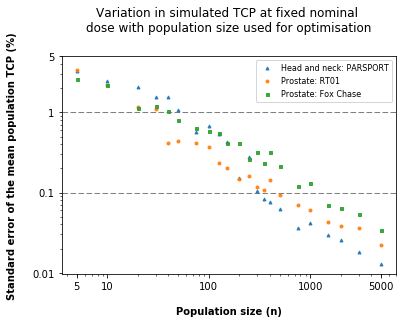

In [9]:
plt.loglog(data_ns,data_hn,ls='',ms=3,marker=marker_hn,label='Head and neck: PARSPORT',alpha=0.9)
plt.loglog(data_ns,data_rt01,ls='',ms=3,marker=marker_p,label='Prostate: RT01',alpha=0.9)
plt.loglog(data_ns,data_fc,ls='',ms=3,marker=marker_fc,label='Prostate: Fox Chase',alpha=0.9)

plt.legend(fontsize=8)

plt.xticks([5,10,100,1000,5000],['5','10','100','1000','5000']) 
plt.yticks([0.01,0.1,1,5],['0.01','0.1','1','5']) 

plt.axhline(0.1,c='black',ls='--',lw=0.5,zorder=0)   
plt.axhline(1,c='black',ls='--',lw=0.5,zorder=0)
plt.xlabel('Population size (n)')
plt.ylabel('Standard error of the mean population TCP (%)')
plt.title('Variation in simulated TCP at fixed nominal \ndose with population size used for optimisation')

#plt.savefig('TCP optimisation simulations-solid.png',dpi=300,bbox_inches='tight')

plt.show()

## Plot of variation of TCP calc with 'n' and number of repeat optimisations

In [4]:
## load data
repeat_1 = np.load(r'n_val_results.pkl')
repeat_5 = np.load(r'n_val_results-5repeats.pkl')

In [5]:
print(np.std(repeat_1[5]['tcp']))
print(repeat_1[5]['sd']*100)
print(np.mean(repeat_1[5]['tcp']))
print(repeat_1[5]['mean']*100) ## check that sds and means match those from the raw data. All Match OK.

7.42806633053
7.42806633053
83.7537373326
83.7537373326


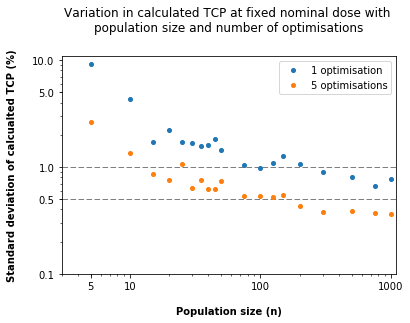

In [6]:
## get mean TCP for each set of data - used to scale the SD to % of TCP
all_1_mean = np.mean([repeat_1[i]['mean'] for i in repeat_1.keys()])
all_5_mean = np.mean([repeat_5[i]['mean'] for i in repeat_5.keys()])

## get SD as a percentage of the mean TCP
all_1_sd = [repeat_1[i]['sd'] for i in sorted(repeat_1.keys())]
all_5_sd = [repeat_5[i]['sd'] for i in sorted(repeat_5.keys())]

## convert sds to percentage of mean TCP
all_1_sd_perc = [100*i/all_1_mean for i in all_1_sd]
all_5_sd_perc = [100*i/all_5_mean for i in all_5_sd]

n_vals = [i for i in sorted(repeat_1.keys())]

## plot the data

plt.loglog(n_vals,all_1_sd_perc,'o', c='C0',ms=4,label='1 optimisation ')
plt.plot(n_vals,all_5_sd_perc,'o',c='C1',ms=4, label='5 optimisations')
plt.ylabel('Standard deviation of calcualted TCP (%)')
plt.xlabel('Population size (n)')
plt.title('Variation in calculated TCP at fixed nominal dose with \npopulation size and number of optimisations')
plt.legend()

#plt.ylim(0.1,10)
plt.yticks([0.1,0.5,1,5,10],['0.1','0.5','1.0','5.0','10.0'])
plt.xlim(3,1100)
plt.xticks([5,10,100,1000],['5','10','100','1000'])
plt.axhline(1,ls='--',c='black',zorder=0,lw=0.5)
plt.axhline(0.5,ls='--',c='black',zorder=0,lw=0.5)

#plt.savefig('N0_determination_n_repeats_variaiton.png',dpi=300,bbox_inches='tight')

plt.show()

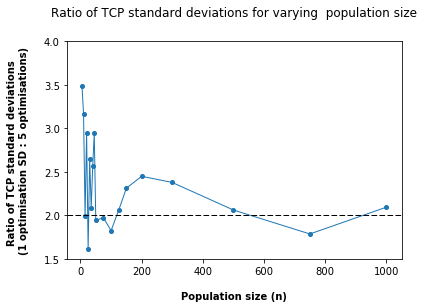

In [7]:
ratios = []
for i in range(len(n_vals)):
    ratios.append(all_1_sd_perc[i]/all_5_sd_perc[i])
plt.plot(n_vals,ratios,ls='-',marker='o',ms='4',lw=1)
plt.axhline(2,c='black',ls='--',lw=1)
plt.ylim(1.5,4)
plt.ylabel('Ratio of TCP standard deviations \n(1 optimisation SD : 5 optimisations)')
plt.xlabel('Population size (n)')
plt.title('Ratio of TCP standard deviations for varying  population size')
plt.show()

## this shows that SD is approximately halved when using 5 repeat optimisaitons for a given n.
## i.e. ~5x more simulations to halve SD

In [8]:
n_vals

[5,
 10,
 15,
 20,
 25,
 30,
 35,
 40,
 45,
 50,
 75,
 100,
 125,
 150,
 200,
 300,
 500,
 750,
 1000]

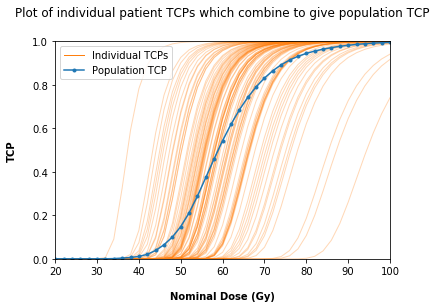

In [9]:
## Produce diagram showing individual patients and population for TCP.
pop_n = 100
TCP_results1 = model.completeTCPcalc(n=pop_n,                  # number of patients in population to model
                                       alphabeta_use=10,       # mean alpha/beta
                                       alphabeta_sd_use=20,    # SD of alpha/beta (%)
                                       d=2,                    # nominal dose (Gy/fraction)
                                       d_shift=0,              # initial dose difference (%)
                                       d_sd=0,                 # standard deviation of delivered dose (%)
                                       d_trend=0,              # dose drift (%/day)
                                       max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                       dose_of_interest=70,    # dose at which to return seperately the TCPs (Gy)
                                       n0 = 1000000,)          # N0 value supplied (if not supplied, then can be fitted)

## plot individual curves
for i in range(pop_n):
    plt.plot(TCP_results1['nom_doses'],TCP_results1['TCPs'][i],c='C1',
             alpha=0.3,lw=1, label = None)
    
## add fake line for legend with alpha = 1
plt.plot([-1,-1],[-1,-1],c='C1',
         alpha=1,lw=1, label = 'Individual TCPs')

## plot population curves
plt.plot(TCP_results1['nom_doses'],TCP_results1['TCP_pop'],ls='-',c='C0',
         label = 'Population TCP', marker='o',ms=3)
plt.xlim(20,100)
plt.ylim(0,1)
plt.legend()

plt.xlabel('Nominal Dose (Gy)')
plt.ylabel('TCP')
plt.title('Plot of individual patient TCPs which combine to give population TCP')

#plt.savefig('pop_tcp_construction.png',dpi=300,bbox_inches='tight')

plt.show()

In [10]:
## example TCP modelling (approx H&N?)

model.completeTCPcalc(n=100,                  # number of patients in population to model
                      alphabeta_use=10,       # mean alpha/beta
                      alphabeta_sd_use=20,    # SD of alpha/beta (%)
                      d=2,                    # nominal dose (Gy/fraction)
                      d_shift=0,              # initial dose difference (%)
                      d_sd=3,                 # standard deviation of delivered dose (%)
                      d_trend=0,              # dose drift (%/day)
                      max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                      dose_of_interest=74,    # results of TCP at this dose are returned seperately for simpler analysis.
                      dose_input=[35,59],     # known doses corresponding to known TCPs to fit to
                      TCP_input=[0.29,0.83],) # known TCPs corresponding to doses to fit to.

N0 not provided - will calculate N0
Fitting N0 value
Fitting N0: Stage 5 of 5N0 fit: 481.776875604

Fitting Completed


{'TCP_cure_percent': 99.980422883245822,
 'TCP_input': [0.29, 0.83],
 'TCP_pop': array([  7.588e-103,   4.015e-054,   8.429e-029,   5.290e-016,
          2.692e-009,   6.697e-006,   3.132e-004,   3.869e-003,
          2.066e-002,   6.737e-002,   1.493e-001,   2.600e-001,
          3.840e-001,   5.069e-001,   6.176e-001,   7.115e-001,
          7.863e-001,   8.445e-001,   8.882e-001,   9.204e-001,
          9.439e-001,   9.606e-001,   9.724e-001,   9.806e-001,
          9.865e-001,   9.906e-001,   9.934e-001,   9.954e-001,
          9.968e-001,   9.977e-001,   9.984e-001,   9.989e-001,
          9.992e-001,   9.994e-001,   9.996e-001,   9.997e-001,
          9.998e-001,   9.999e-001,   9.999e-001,   9.999e-001,
          1.000e+000,   1.000e+000,   1.000e+000,   1.000e+000,
          1.000e+000,   1.000e+000,   1.000e+000,   1.000e+000,
          1.000e+000,   1.000e+000]),
 'TCPs': array([[  1.210e-130,   1.255e-076,   2.374e-047, ...,   1.000e+000,
           1.000e+000,   1.000e+000]

## Sensitivity of TCP parameters

## Prostate
### Standard values for population to find N0
- a/b = 1.5
     - Fowler J, Chappell R, Ritter M. Is α/β for prostate tumors really low? Int J Radiat Oncol. 2001 Jul;50(4):1021–31. 
     - Dale textbook
     - Wedenberg M. FROM CELL SURVIVAL TO DOSE RESPONSE – MODELING BIOLOGICAL EFFECTS IN RADIATION THERAPY. Karolinska Institutet; 2013. 
     
- a/b SD = 50% [Dale textbook] = chosen to fit the plots best. Ideally this would be fitted with N0, but not currently possible.
- N0 = to be fitted from population data
- n = 1000
- d = 2
- d_shift = 0
- d_trend = 0
- d_interest = 74Gy (common treatment dose at start of project, CHHiP altered change this for many)
- TCP input (supplied as value between 0-1 in model):
    - 10 year bPFS: 43% [38-48] at 64Gy and 55% [50-61] at 74Gy [95%CI]
        - Dearnaley DP, Jovic G, Syndikus I, Khoo V, Cowan R a, Graham JD, et al. Escalated-dose versus control-dose conformal radiotherapy for prostate cancer: long-term results from the MRC RT01 randomised controlled trial. Lancet Oncol. 2014 Apr;15(4):464–73. 
    - 5 year bPFS: 60% at 64Gy and 71% at 74Gy [95% CI is not stated in paper...]
        - Dearnaley DP, Sydes MR, Graham JD, Aird EG, Bottomley D, Cowan R a., et al. Escalated-dose versus standard-dose conformal radiotherapy in prostate cancer: first results from the MRC RT01 randomised controlled trial. Lancet Oncol. 2007;8:475–87.
        
- Beta value - [probably got more refs too]:
    - Hawkins RB. Clinical and Translational Radiation Oncology Effect of heterogeneous radio sensitivity on the survival , alpha beta ratio and biologic effective dose calculation of irradiated mammalian cell populations. Clin Transl Radiat Oncol. 2017;4:32–8. 


In [12]:
## example TCP modelling - prostate 10 year survival
do_modelling = True
if do_modelling == True: ## do not need to do this if can just load previous results.
    
    prost_10year = model.completeTCPcalc(n=1000,                  # number of patients in population to model
                          alphabeta_use=1.5,       # mean alpha/beta
                          alphabeta_sd_use=50,    # SD of alpha/beta (%)
                          d=2,                    # nominal dose (Gy/fraction)
                          d_shift=0,              # initial dose difference (%)
                          d_sd=0,                 # standard deviation of delivered dose (%)
                          d_trend=0,              # dose drift (%/day)
                          max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                          dose_of_interest=74,    # results of TCP at this dose are returned seperately for simpler analysis.
                          dose_input=[64,74],     # known doses corresponding to known TCPs to fit to
                          TCP_input=[0.43,0.55],) # known TCPs corresponding to doses to fit to.

## this gives N0 = 73.5741569407

## beta value 1. Hawkins RB. Clinical and Translational Radiation Oncology Effect of heterogeneous radio sensitivity on the survival , alpha beta ratio and biologic effective dose calculation of irradiated mammalian cell populations. Clin Transl Radiat Oncol. 2017;4:32–8. 

N0 not provided - will calculate N0
Fitting N0 value
Fitting N0: Stage 5 of 5N0 fit: 74.2710368956

Fitting Completed


In [12]:
## save the above results:
#save_pkl(prost_10year,'prost_10year-N0_determination.pkl')

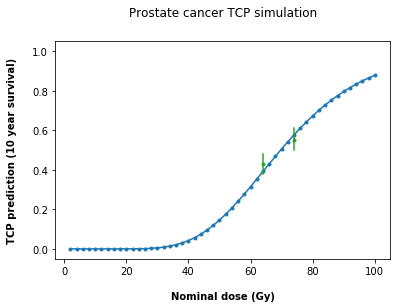

In [13]:
## select the data to plot for ease - load from saved file
plot_data = load_pkl('prost_10year-N0_determination.pkl') #prost_10year

## add some confidence intervals to the fit points
tcp_conf_intervals_1 = [0.38,0.48] # at 64Gy ## 95% CI from paper
tcp_conf_intervals_2 = [0.50,0.61] # at 74Gy

plt.plot(plot_data['nom_doses'],plot_data['TCP_pop'],marker='o',ms=3)


for i in [0,1]:
    plt.plot(plot_data['dose_input'][i],plot_data['TCP_input'][i],'o',ms=3,c='C2')
    if i == 0:
        tcp = tcp_conf_intervals_1
    if i == 1:
        tcp = tcp_conf_intervals_2
    plt.plot([plot_data['dose_input'][i]]*2,tcp,c='C2')
plt.xlabel('Nominal dose (Gy)')
plt.ylabel('TCP prediction (10 year survival)')
plt.title('Prostate cancer TCP simulation')

plt.ylim(-0.05,1.05)
plt.show()

In [14]:
## examine the data
plot_data['n0_use'] ## this is the N0 value which was determined from the above.

73.574156940716279

## Now simulate a single 'average' patient to determine parameter sensitivity
- No fitting required as N0 already determined.

In [15]:
prost_patient = model.completeTCPcalc(n=1,                  # number of patients in population to model
                      alphabeta_use=1.5,       # mean alpha/beta
                      alphabeta_sd_use=0,    # SD of alpha/beta (%)
                      d=2,                    # nominal dose (Gy/fraction)
                      d_shift=0,              # initial dose difference (%)
                      d_sd=0,                 # standard deviation of delivered dose (%)
                      d_trend=0,              # dose drift (%/day)
                      max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                      dose_of_interest=74,    # results of TCP at this dose are returned seperately for simpler analysis.
                      dose_input=[64,74],     # known doses corresponding to known TCPs to fit to
                      TCP_input=[0.43,0.55],
                      n0 = 74) # N0 as determnined through population fit

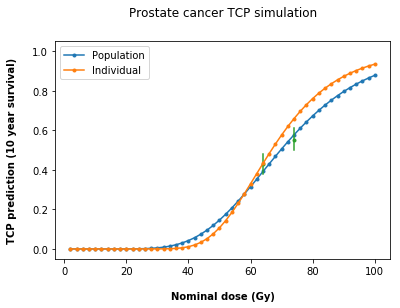

In [16]:
## select the data to plot for ease - load from saved file
plot_data = load_pkl('prost_10year-N0_determination.pkl') #prost_10year

## add some confidence intervals to the fit points
tcp_conf_intervals_1 = [0.38,0.48] # at 64Gy ## 95% CI from paper
tcp_conf_intervals_2 = [0.50,0.61] # at 74Gy

plt.plot(plot_data['nom_doses'],plot_data['TCP_pop'],marker='o',ms=3, label='Population')


for i in [0,1]:
    plt.plot(plot_data['dose_input'][i],plot_data['TCP_input'][i],'o',ms=3,c='C2')
    if i == 0:
        tcp = tcp_conf_intervals_1
    if i == 1:
        tcp = tcp_conf_intervals_2
    plt.plot([plot_data['dose_input'][i]]*2,tcp,c='C2')

plt.plot(prost_patient['nom_doses'],prost_patient['TCP_pop'],marker='o',ms=3, label='Individual')

plt.xlabel('Nominal dose (Gy)')
plt.ylabel('TCP prediction (10 year survival)')
plt.title('Prostate cancer TCP simulation')

plt.ylim(-0.05,1.05)

plt.legend()
plt.show()


## if the 'average' N0 is used then TCP predicted is less well matched through the points.
## This is due to the lognormal alpha distribution...?
## continue to use as sensitivity unlikely to be affected by precise position of curve.

my_ab
{'my_n0': 74, 'my_ab': 1.5, 'my_d': 2}
{'my_n0': 74, 'my_ab': 1.53, 'my_d': 2}
my_d
{'my_n0': 74, 'my_ab': 1.5, 'my_d': 2}
{'my_n0': 74, 'my_ab': 1.5, 'my_d': 2.04}
my_n0
{'my_n0': 74, 'my_ab': 1.5, 'my_d': 2}
{'my_n0': 75.48, 'my_ab': 1.5, 'my_d': 2}
*New TCP Results*
{'my_n0': 65.389929395557516, 'my_ab': 67.140308692963231, 'my_d': 66.470716196986572}
Original TCP result
65.9368661888


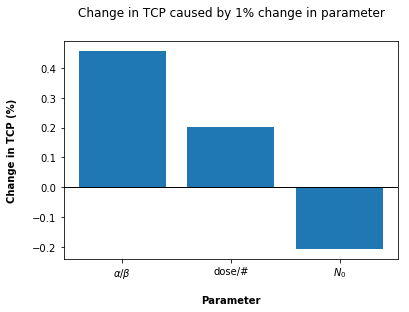

Sensitivity per % change in parameter
my_n0 -0.207371393612
my_ab 0.45628590411
my_d 0.20240953165


In [17]:
## now want to vary the parameters by a known amount (2%) to see the effect on the TCP at a specific dose (74Gy).
the_perc_dif = 2 # percentage variation to use
fact = 1+(the_perc_dif/100)
## more values will be completed for dose for the 'impact' section of the thesis.

## set the standard values which will be allowed to vary

## thse are the 3 main parameters which will affect a single patient. Others effect the fitting/populations
param_dict = {'my_ab':1.5,
              'my_d':2,
              'my_n0':74
              }

## loop the parameters to change them

all_params = sorted(param_dict) ## sort this for consistent use

results = {}

for param in all_params:
    
    param_dict_var = {k:v for (k,v) in param_dict.items()}
    param_dict_var[param] = param_dict[param]*fact ## increase one param by the factor
    
    print(param)
    print(param_dict)
    print(param_dict_var)


    prost_patient_dif = model.completeTCPcalc(n=1,  # number of patients in population to model
                          alphabeta_use=param_dict_var['my_ab'],       # mean alpha/beta
                          alphabeta_sd_use=0,    # SD of alpha/beta (%)
                          d=param_dict_var['my_d'],                    # nominal dose (Gy/fraction)
                          d_shift=0,              # initial dose difference (%)
                          d_sd=0,                 # standard deviation of delivered dose (%)
                          d_trend=0,              # dose drift (%/day)
                          max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                          dose_of_interest=74,    # results of TCP at this dose are returned seperately for simpler analysis.
                          n0 = param_dict_var['my_n0']) # N0 as determnined through population fit
    results[str(param)] = prost_patient_dif['TCP_cure_percent']

print('*New TCP Results*')
print(results) ## this is the TCP at 74Gy with the adjusted parameters

print('Original TCP result')
print(prost_patient['TCP_cure_percent'])

## now compare this TCP with the original
perc_dif = {}
for param in all_params:
    orig = prost_patient['TCP_cure_percent']
    new = results[param]
    the_dif = ((new/orig)-1)*100
    perc_dif[param] = the_dif/the_perc_dif ## devide by the percentage dif 
perc_dif

## quick plot
labels = [i for i in all_params]
formatted_labels = [r'$\alpha / \beta$', 'dose/#',r'$N_0$']
values = [perc_dif[i]/2 for i in all_params]
posns = [i for i in range(len(values))]
plt.bar(posns,values,tick_label=formatted_labels)
plt.axhline(0,color='black',lw=1,ls='-')
plt.ylabel('Change in TCP (%)')
plt.xlabel('Parameter')
plt.title('Change in TCP caused by 1% change in parameter')
#plt.savefig('prost_param_sensitivity.png',dpi=300,bbox_inches='tight')
plt.show()


print('Sensitivity per % change in parameter')
for i in perc_dif:
    print(i,perc_dif[i]/2)
## these are relatively low values due to shallow curve.

In [18]:
perc_dif

{'my_ab': 0.9125718082200196,
 'my_d': 0.4048190632995996,
 'my_n0': -0.41474278722404279}

## H&N
- Get data for this and run in same way as above to get sensitivities.
- could put all data on same plot to indicate difference, depends how marked the differences are.

- Data from
    - Nutting CM, Morden JP, Harrington KJ, Urbano TG, Bhide SA, Clark C, et al. Parotid-sparing intensity modulated versus conventional radiotherapy in head and neck cancer (PARSPORT): A phase 3 multicentre randomised controlled trial. Lancet Oncol. 2011;12(2):127–36. 
    
- Dose to PTV = 65Gy (median)
- TCP = {66% survival at 2 years} 79% [63-89 CI] from above paper (2 year locoregional progression-free survival survival average from IMRT (78% [62-87=95% CI]) and Converntional (80% [65-90 = 95%CI]) (no sig dif between IMRT and conf). conventional radiotherapy 80% (95% CI 65 to 90) and for IMRT 78% (62 to 87)
- ***TCP used = 2 year overall survival = 66%. Based on 38 total deaths of 47x7=94 patients.
- a/b = 10 [numerous papers etc...]
- a/b SD - same as for prostate = 50% as this was a good fit to the model, so reasonable assumption
- d = 65/30 Gy/# = 2.167Gy/#
- d_interest = 65Gy

In [12]:
## example TCP modelling - H&N 5 year survival

do_modelling = True

for i in range(5):
    if do_modelling == True: ## do not need to do this if can just load previous results.

        hn_5year = model.completeTCPcalc(n=1,                  # number of patients in population to model
                              alphabeta_use=10,       # mean alpha/beta
                              alphabeta_sd_use=0,    # SD of alpha/beta (%)
                              d=65/30,                    # nominal dose (Gy/fraction)
                              d_shift=0,              # initial dose difference (%)
                              d_sd=0,                 # standard deviation of delivered dose (%)
                              d_trend=0,              # dose drift (%/day)
                              max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                              dose_of_interest=65,    # results of TCP at this dose are returned seperately for simpler analysis.
                              dose_input=[65],     # known doses corresponding to known TCPs to fit to
                              TCP_input=[0.66],) # known TCPs corresponding to doses to fit to.
    #print(hn_5year['n0_use'])
    
## fitting didnt work well here. Very inconsistent... repeat multiple times and average

N0 not provided - will calculate N0
Fitting N0 value
Fitting N0: Stage 5 of 5N0 fit: 3073818.54262

Fitting Completed
N0 not provided - will calculate N0
Fitting N0 value
Fitting N0: Stage 5 of 5N0 fit: 3073818.54262

Fitting Completed
N0 not provided - will calculate N0
Fitting N0 value
Fitting N0: Stage 5 of 5N0 fit: 3073818.54262

Fitting Completed
N0 not provided - will calculate N0
Fitting N0 value
Fitting N0: Stage 5 of 5N0 fit: 3073818.54262

Fitting Completed
N0 not provided - will calculate N0
Fitting N0 value
Fitting N0: Stage 5 of 5N0 fit: 3073818.54262

Fitting Completed


In [20]:
all_n0 = [2162.57839909,26848.8740655,821.302040827,12425.0540082,9564.69489905]
all_n0_1 = [484.480495083,378.041498923,177.868736443,5435.23209056,9527.98421258]
print(np.mean(all_n0))
print(np.mean(all_n0_1))
## mean N0 ~ 10000 - use this value or slightly higher gives a better fit.

10364.5006825
3200.72140672


In [21]:
## save the above results:
#save_pkl(hn_5year1,'hn_5year1-N0_determination.pkl')

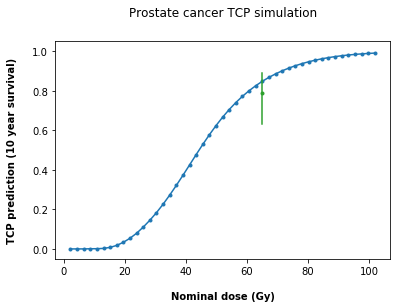

In [22]:
## select the data to plot for ease - load from saved file
plot_data = load_pkl('hn_5year-N0_determination.pkl') #prost_10year

## add some confidence intervals to the fit points
tcp_conf_intervals_1 = [0.63,0.89] # at 65Gy ## 95% CI from paper

plt.plot(plot_data['nom_doses'],plot_data['TCP_pop'],marker='o',ms=3)


for i in [0]:
    plt.plot(plot_data['dose_input'][i],plot_data['TCP_input'][i],'o',ms=3,c='C2')
    if i == 0:
        tcp = tcp_conf_intervals_1
    if i == 1:
        tcp = tcp_conf_intervals_2
    plt.plot([plot_data['dose_input'][i]]*2,tcp,c='C2')
plt.xlabel('Nominal dose (Gy)')
plt.ylabel('TCP prediction (10 year survival)')
plt.title('Prostate cancer TCP simulation')

plt.ylim(-0.05,1.05)
plt.show()

In [23]:
## examine the data
plot_data['n0_use'] ## this is the N0 value which was determined from the above.

9527.9842125756841

In [13]:
hn_patient = model.completeTCPcalc(n=1,                  # number of patients in population to model
                      alphabeta_use=10,       # mean alpha/beta
                      alphabeta_sd_use=0,    # SD of alpha/beta (%)
                      d=65/30,                    # nominal dose (Gy/fraction)
                      d_shift=0,              # initial dose difference (%)
                      d_sd=0,                 # standard deviation of delivered dose (%)
                      d_trend=0,              # dose drift (%/day)
                      max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                      dose_of_interest=65,    # results of TCP at this dose are returned seperately for simpler analysis.
                      dose_input=[65],     # known doses corresponding to known TCPs to fit to
                      TCP_input=[0.79],
                      n0 = 1500000) # N0 as determnined through population fit

## large value of N0 used (manually determined to make sure it is appropriate.) - steep gradient required

NameError: name 'tcp_conf_intervals_1' is not defined

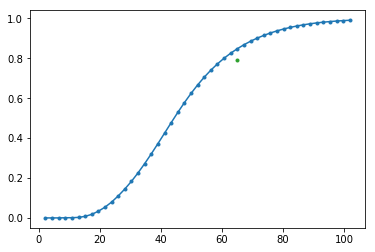

In [14]:
## select the data to plot for ease - load from saved file
plot_data = load_pkl('hn_5year-N0_determination.pkl') #prost_10year

plt.plot(plot_data['nom_doses'],plot_data['TCP_pop'],marker='o',ms=3, label='Population')


for i in [0]:
    plt.plot(plot_data['dose_input'][i],plot_data['TCP_input'][i],'o',ms=3,c='C2')
    if i == 0:
        tcp = tcp_conf_intervals_1
    if i == 1:
        tcp = tcp_conf_intervals_2
    plt.plot([plot_data['dose_input'][i]]*2,tcp,c='C2')

plt.plot(hn_patient['nom_doses'],hn_patient['TCP_pop'],marker='o',ms=3, label='Individual')

plt.xlabel('Nominal dose (Gy)')
plt.ylabel('TCP prediction (10 year survival)')
plt.title('Prostate cancer TCP simulation')

plt.ylim(-0.05,1.05)

plt.legend()
plt.show()

## N0 was set manually for hte individual 'average' pateint
## individual curve is much steeper

In [15]:
## now want to vary the parameters by a known amount (2%) to see the effect on the TCP at a specific dose (74Gy).
the_perc_dif = 2 # percentage variation to use
fact = 1+(the_perc_dif/100)
## more values will be completed for dose for the 'impact' section of the thesis.

## set the standard values which will be allowed to vary

## thse are the 3 main parameters which will affect a single patient. Others effect the fitting/populations
param_dict = {'my_ab':10,
              'my_d':65/30,
              'my_n0':1500000
              }

## loop the parameters to change them

all_params = sorted(param_dict) ## sort this for consistent use

results = {}

for param in all_params:
    
    param_dict_var = {k:v for (k,v) in param_dict.items()}
    param_dict_var[param] = param_dict[param]*fact ## increase one param by the factor
    
    print(param)
    print(param_dict)
    print(param_dict_var)


    hn_patient_dif = model.completeTCPcalc(n=1,  # number of patients in population to model
                          alphabeta_use=param_dict_var['my_ab'],       # mean alpha/beta
                          alphabeta_sd_use=0,    # SD of alpha/beta (%)
                          d=param_dict_var['my_d'],                    # nominal dose (Gy/fraction)
                          d_shift=param_dict_var,              # initial dose difference (%)
                          d_sd=0,                 # standard deviation of delivered dose (%)
                          d_trend=0,              # dose drift (%/day)
                          max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                          dose_of_interest=65,    # results of TCP at this dose are returned seperately for simpler analysis.
                          n0 = param_dict_var['my_n0']) # N0 as determnined through population fit
    results[str(param)] = hn_patient_dif['TCP_cure_percent']

print('*New TCP Results*')
print(results) ## this is the TCP at 74Gy with the adjusted parameters

print('Original TCP result')
print(hn_patient['TCP_cure_percent'])

## now compare this TCP with the original
perc_dif = {}
for param in all_params:
    orig = hn_patient['TCP_cure_percent']
    new = results[param]
    the_dif = ((new/orig)-1)*100
    perc_dif[param] = the_dif/the_perc_dif ## devide by the percentage dif 
perc_dif

## quick plot
labels = [i for i in all_params]
formatted_labels = [r'$\alpha / \beta$', 'dose/#',r'$N_0$']
values = [perc_dif[i]/2 for i in all_params]
posns = [i for i in range(len(values))]
plt.bar(posns,values,tick_label=formatted_labels)
plt.axhline(0,color='black',lw=1,ls='-')
plt.ylabel('Change in TCP (%)')
plt.xlabel('Parameter')
plt.title('Change in TCP caused by 1% change in parameter')
#plt.savefig('hn_param_sensitivity.png',dpi=300,bbox_inches='tight')
plt.show()


print('Sensitivity per % change in parameter')
for i in perc_dif:
    print(i,perc_dif[i]/2)
## these are relatively low values due to shallow curve.

my_ab
{'my_d': 2.1666666666666665, 'my_ab': 10, 'my_n0': 1500000}
{'my_d': 2.1666666666666665, 'my_ab': 10.2, 'my_n0': 1500000}


TypeError: unsupported operand type(s) for *: 'float' and 'dict'

In [18]:

## do manually...as its easier to keep track.
print('------H&N------')
print('TCP for dose dif of 0 and +1%')
dose_dif = [0,1]

for the_fact in dose_dif:

    hn_patient1 = model.completeTCPcalc(n=1,                  # number of patients in population to model
                          alphabeta_use=10,       # mean alpha/beta
                          alphabeta_sd_use=0,    # SD of alpha/beta (%)
                          d=65/30,                    # nominal dose (Gy/fraction)
                          d_shift=the_fact,              # initial dose difference (%)
                          d_sd=0,                 # standard deviation of delivered dose (%)
                          d_trend=0,              # dose drift (%/day)
                          max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                          dose_of_interest=65,    # results of TCP at this dose are returned seperately for simpler analysis.
                          n0 = 3000000) # N0 as determnined through population fit
    print(the_fact,hn_patient1['TCP_cure_percent'])

print('')
print('TCP for ab dif of 0 and +1%')
ab_fact = [1,1.01]

for the_fact in ab_fact:

    hn_patient1 = model.completeTCPcalc(n=1,                  # number of patients in population to model
                          alphabeta_use=10*the_fact,       # mean alpha/beta
                          alphabeta_sd_use=0,    # SD of alpha/beta (%)
                          d=65/30,                    # nominal dose (Gy/fraction)
                          d_shift=0,              # initial dose difference (%)
                          d_sd=0,                 # standard deviation of delivered dose (%)
                          d_trend=0,              # dose drift (%/day)
                          max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                          dose_of_interest=65,    # results of TCP at this dose are returned seperately for simpler analysis.
                          n0 = 3000000) # N0 as determnined through population fit
    print(the_fact,hn_patient1['TCP_cure_percent'])
    
print('')
print('TCP for N0 dif of 0 and +1%')
n0_fact = [1,1.01]

for the_fact in n0_fact:

    hn_patient1 = model.completeTCPcalc(n=1,                  # number of patients in population to model
                          alphabeta_use=10,       # mean alpha/beta
                          alphabeta_sd_use=0,    # SD of alpha/beta (%)
                          d=65/30,                    # nominal dose (Gy/fraction)
                          d_shift=0,              # initial dose difference (%)
                          d_sd=0,                 # standard deviation of delivered dose (%)
                          d_trend=0,              # dose drift (%/day)
                          max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                          dose_of_interest=65,    # results of TCP at this dose are returned seperately for simpler analysis.
                          n0 = 3000000*the_fact) # N0 as determnined through population fit
    print(the_fact,hn_patient1['TCP_cure_percent'])

------H&N------
TCP for dose dif of 0 and +1%
0 66.6618917755
1 71.4266289801

TCP for ab dif of 0 and +1%
1 66.6618917755
1.01 70.0402609232

TCP for N0 dif of 0 and +1%
1 66.6618917755
1.01 66.3921007374


In [17]:

## do manually...as its easier to keep track.
print('------Prostate------')
print('TCP for dose dif of 0 and +1%')
dose_dif = [0,1]

prost_perc_difs = {}

for the_fact in dose_dif:

    prost_patient1 = model.completeTCPcalc(n=1,                  # number of patients in population to model
                          alphabeta_use=1.5,       # mean alpha/beta
                          alphabeta_sd_use=0,    # SD of alpha/beta (%)
                          d=2,                    # nominal dose (Gy/fraction)
                          d_shift=the_fact,              # initial dose difference (%)
                          d_sd=0,                 # standard deviation of delivered dose (%)
                          d_trend=0,              # dose drift (%/day)
                          max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                          dose_of_interest=74,    # results of TCP at this dose are returned seperately for simpler analysis.
                          n0 = 74) # N0 as determnined through population fit
    print(the_fact,prost_patient1['TCP_cure_percent'])

print('')
print('TCP for ab dif of 0 and +1%')
ab_fact = [1,1.01]

for the_fact in ab_fact:

    prost_patient1 = model.completeTCPcalc(n=1,                  # number of patients in population to model
                          alphabeta_use=1.5*the_fact,       # mean alpha/beta
                          alphabeta_sd_use=0,    # SD of alpha/beta (%)
                          d=2,                    # nominal dose (Gy/fraction)
                          d_shift=0,              # initial dose difference (%)
                          d_sd=0,                 # standard deviation of delivered dose (%)
                          d_trend=0,              # dose drift (%/day)
                          max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                          dose_of_interest=74,    # results of TCP at this dose are returned seperately for simpler analysis.
                          n0 = 74) # N0 as determnined through population fit
    print(the_fact,prost_patient1['TCP_cure_percent'])
    
print('')
print('TCP for N0 dif of 0 and +1%')
n0_fact = [1,1.01]

for the_fact in n0_fact:

    prost_patient1 = model.completeTCPcalc(n=1,                  # number of patients in population to model
                          alphabeta_use=1.5,       # mean alpha/beta
                          alphabeta_sd_use=0,    # SD of alpha/beta (%)
                          d=2,                    # nominal dose (Gy/fraction)
                          d_shift=0,              # initial dose difference (%)
                          d_sd=0,                 # standard deviation of delivered dose (%)
                          d_trend=0,              # dose drift (%/day)
                          max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                          dose_of_interest=74,    # results of TCP at this dose are returned seperately for simpler analysis.
                          n0 = 74*the_fact) # N0 as determnined through population fit
    print(the_fact,prost_patient1['TCP_cure_percent'])
    


------Prostate------
TCP for dose dif of 0 and +1%
0 65.9368661888
1 68.1266937948

TCP for ab dif of 0 and +1%
1 65.9368661888
1.01 66.5425457205

TCP for N0 dif of 0 and +1%
1 65.9368661888
1.01 65.6628283327


Calculated TCP values. Need to convert to sensitivities

### ------H&N------
TCP for dose dif of 0 and +1%
0 81.6467340287
1 84.514276297

TCP for ab dif of 0 and +1%
1 81.6467340287
1.01 83.6900596984

TCP for N0 dif of 0 and +1%
1 81.6467340287
1.01 81.4813480113

### ----------- H&N2 --------

------H&N------
TCP for dose dif of 0 and +1%
0 66.6618917755
1 71.4266289801

TCP for ab dif of 0 and +1%
1 66.6618917755
1.01 70.0402609232

TCP for N0 dif of 0 and +1%
1 66.6618917755
1.01 66.3921007374


### ------Prostate------
TCP for dose dif of 0 and +1%
0 65.9368661888
1 68.1266937948

TCP for ab dif of 0 and +1%
1 65.9368661888
1.01 66.5425457205

TCP for N0 dif of 0 and +1%
1 65.9368661888
1.01 65.6628283327

Summary:
Dose sensitivity
HN:((71.4266289801/66.6618917755)-1)*100
Prostate((68.1266937948/65.9368661888)-1)*100

A:B sensitivity
HN:((70.0402609232/66.6618917755)-1)*100
Prostate((66.5425457205/65.9368661888)-1)*100

N0 sensitivity
HN:((66.3921007374/66.6618917755)-1)*100
Prostate((65.6628283327/65.9368661888)-1)*100

In [19]:
## the above in code so can use and plot etc.

sensitivity = {'dose':{
'hn':((71.4266289801/66.6618917755)-1)*100,
'prostate':((68.1266937948/65.9368661888)-1)*100},

'ab':{
'hn':((70.0402609232/66.6618917755)-1)*100,
'prostate':((66.5425457205/65.9368661888)-1)*100},

'n0':{
'hn':((66.3921007374/66.6618917755)-1)*100,
'prostate':((65.6628283327/65.9368661888)-1)*100}
    }

sensitivity

{'ab': {'hn': 5.06791670281046, 'prostate': 0.9185749440468349},
 'dose': {'hn': 7.147617743352397, 'prostate': 3.321097486995783},
 'n0': {'hn': -0.4047155442401529, 'prostate': -0.41560643072622305}}

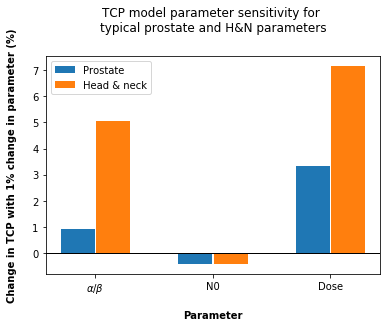

[0.9185749440468349, -0.41560643072622305, 3.321097486995783]
[5.06791670281046, -0.4047155442401529, 7.147617743352397]
['$\\alpha / \\beta$', 'N0', 'Dose']


In [22]:
## plot each set of data:

labels = {'ab':r'$\alpha / \beta$',
         'dose': 'Dose',
         'n0':'N0'}

my_param = []
hn = []
prostate = []
use_labels = []
for i in sensitivity:
    my_param.append(i)
    hn.append(sensitivity[i]['hn'])
    prostate.append(sensitivity[i]['prostate'])
    use_labels.append(labels[i])

offset = 0.15
#plt.bar(posns,values,tick_label=formatted_labels)

width = 0.29
hn_posn = [i+offset for i in range(3)]
prost_posn = [i-offset for i in range(3)]

plt.bar(prost_posn,prostate,tick_label=use_labels,color='C0',width=width,label='Prostate')
plt.bar(hn_posn,hn,tick_label=use_labels,color='C1',width=width,label='Head & neck')
plt.xticks(range(3),use_labels)
plt.axhline(0,color='black',lw=1)

plt.ylabel('Change in TCP with 1% change in parameter (%)')
plt.xlabel('Parameter')
plt.title('TCP model parameter sensitivity for \ntypical prostate and H&N parameters')

#plt.ylim(-1,4)
plt.legend()

#plt.savefig('param_sensitivity-prost_hn2.png',dpi=300,bbox_inches='tight')

plt.show()


print(prostate)
print(hn)
print(use_labels)

# NTCP Characterisation

Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***


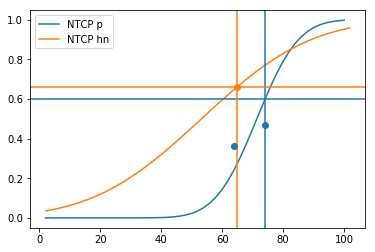

p TCP: 0.597382175553
hn TCP: 0.661886810255


In [5]:
## Example dose calculation.
## The values of V were determined by optimising the curve fit based on the supplied dose/NTPC values.

## this TCP part is only used to get a list of fraction doses and nominal doses
## this is easiest as the dose variaiotn is builtin.
TCP_results_p = model.completeTCPcalc(n=1,
                                      alphabeta_use=1.5,
                                      alphabeta_sd_use=0,
                                      d=2,
                                      d_shift=0, # no shift as start each treatment as if perfect
                                      d_sd=0,
                                      d_trend=0, # vary the trend value
                                      max_d=100,
                                      dose_of_interest=74,
                                      n0 = 74) ##*********

TCP_results_hn = model.completeTCPcalc(n=1,
                                      alphabeta_use=10,
                                      alphabeta_sd_use=0,
                                      d=65/30,
                                      d_shift=0, # no shift as start each treatment as if perfect
                                      d_sd=0,
                                      d_trend=0, # vary the trend value
                                      max_d=100,
                                      dose_of_interest=65,
                                      n0 = 3000000) ##*********

frac_doses_p = TCP_results_p['doses']
nom_doses_p = TCP_results_p['nom_doses']
frac_doses_hn = TCP_results_hn['doses']
nom_doses_hn = TCP_results_hn['nom_doses'] 

## v is manually determined based ont he TCP/dose points

NTCP_results_p = model.complete_NTCP_calc(d_data=[64,74],
                                       ntcp_data=[0.36,0.47],
                                       irrad_perc = 100, ## scaling factor?
                                       frac_doses=frac_doses_p,
                                       max_dose=100,
                                       ntcp_params={'td50_1':(68.5,0),
                                                    'v': (0.73,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                    'm':(0.15,0),
                                                    'n':(0.13,0)}, #(1,0)
                                       fit_vals=False)

NTCP_results_hn = model.complete_NTCP_calc(d_data=[65],
                                       ntcp_data=[0.66],
                                       irrad_perc = 100, ## scaling factor?
                                       frac_doses=frac_doses_hn,
                                       max_dose=100,
                                       ntcp_params={'td50_1':(31.4,0),
                                                    'v': (0.59,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                    'm':(0.53,0),
                                                    'n':(1,0)}, #(1,0)
                                       fit_vals=False)

plt.plot(nom_doses_p,NTCP_results_p['patient_ntcps'][0],label='NTCP p')
plt.plot(nom_doses_hn,NTCP_results_hn['patient_ntcps'][0],label='NTCP hn')
## show dose of interest point
plt.axvline(74,c=color_p)
plt.axhline(NTCP_results_p['patient_ntcps'][0][36],c=color_p)
plt.axvline(65,c=color_hn)
plt.axhline(NTCP_results_hn['patient_ntcps'][0][29],c=color_hn)

## show dose points
plt.plot(NTCP_results_p['d_data'],NTCP_results_p['ntcp_data'],'o',c=color_p)
plt.plot(NTCP_results_hn['d_data'],NTCP_results_hn['ntcp_data'],'o',c=color_hn)

plt.legend()
plt.show()

## get TCP at doses of interest.

print('p TCP:',NTCP_results_p['patient_ntcps'][0][36])
print('hn TCP:',NTCP_results_hn['patient_ntcps'][0][29])